In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth

import timeit
import Double_Null_utils as dnu
from scipy import optimize
import tables
from mpmath import *


In [2]:
###Initial Values###

M0=1.0
Q=0.95
Lambda=0.0000
scalarfield=False
vscalarfield=False


In [3]:
Tol=1
N=10
#Nul=100
#Nup=10**(40)
scal=1
umax=13
vmax=200
datatype=np.float64

rlim=.2/N
siglim=10/N
philim=5/N


#ru0=5.0
#dr0v=.4
ru0=5.0
#dr0v=0.045
dr0u=-.375
dr0v=-1/(4*dr0u)*(1-2*M0/ru0+Q**2/ru0**2)

#dr0v=0.045

bdytype="stan"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]

In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du0=1/N
    dv0=1/N    
else:
    du0=M0/N
    dv0=M0/N
    


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda>0 or Lambda<0:
    sol = optimize.root(fr,[0.687,1.3,50.0],args=(M0,Q,Lambda), method='hybr')
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
else:
    rplus=M0+(M0**2-Q**2)**(.5)
    rminus=M0-(M0**2-Q**2)**(.5)
    rcosm=0.0
    

wHD=True 

print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=N*umax#Nul*umax*100#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(78000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.31224989991992
r-: 0.6877501000800801
rc: 0.0
Number of points for highest iteration is 260000,130X2000
Total number of points is 260000
Runtime: about 0.06 minutes


In [5]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])


rnpf=np.zeros((2,Nu),dtype=datatype)
signpf=np.zeros((2,Nu),dtype=datatype)
phinpf=np.zeros((2,Nu),dtype=datatype)
massnpf=np.full((2,Nu),M0)#np.zeros((2,Nv))
drunpv=np.full((1,Nu-1),-1/(4*dr0v)*(1-2*M0/ru0+Q**2/ru0**2))
 

#write version of boundary for u-boundary
rnpf[0], signpf[0], phinpf[0] = dnu.boundaryu(scal,bdytype,Nu,ru0,dr0u,dv0,umax,M0,Q,Lambda,scalarfield,datatype)


Using Standard Coordinates Along V


In [6]:
drunptemp=np.empty((Nv))*np.nan



A=.115
u1=9.5
u2=10

###Applying Propagation Algorithm###

urange=np.arange(0,umax,du0)
dulist=np.full(Nu-1,0)
vrange=np.array([0.0],dtype=datatype)
drvnp=np.array([0.0],dtype=datatype)
dsigvnp=np.array([0.0],dtype=datatype)
dphinpvf=np.array([0.0],dtype=datatype)
massnpf[0][0]=1.0

drvnp[0]=dr0v#-mth.exp(signpf[0][0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda*ru0**2/3)
dsigvnpvalue=100*np.exp(np.nanmax(signpf))
drvnptemp=drvnp[0]
    

i=0
dv=dv0
if M0>0:
    du0=M0/N
elif M0==0:
    du0=1/N

du=du0

if bdytype=="edd" or bdytype=="fulledd":
    bdyvalue=1.0
    dsigvnp[0]=2*(3*Q**2-3*M0*ru0+ru0**4*Lambda)/(ru0*(-3*Q**2+ru0*(6*M0-3*ru0+ru0**3*Lambda)))*drunp[0]
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
else:
    bdyvalue=0.0
    dsigvnp[0]=0.0
 
atom = tables.Float64Atom()

rnpfile = tables.open_file('rnp.h5', mode='w',encoding="utf8") 
rnp = rnpfile.create_earray(rnpfile.root, 'data', atom, (0, Nu))

signpfile = tables.open_file('signp.h5', mode='w',encoding="utf8") 
signp = signpfile.create_earray(signpfile.root, 'data', atom, (0, Nu))
phinpfile = tables.open_file('phinp.h5', mode='w',encoding="utf8") 
phinp = phinpfile.create_earray(phinpfile.root, 'data', atom, (0, Nu))
massnpfile = tables.open_file('massnp.h5', mode='w',encoding="utf8") 
massnp = massnpfile.create_earray(massnpfile.root, 'data', atom, (0, Nu))
    
 
#rtemp=rnpf[0]   
#print(rtemp)

rnp.append(rnpf[0].reshape(1,Nu))
signp.append(signpf[0].reshape(1,Nu))
phinp.append(phinpf[0].reshape(1,Nu))
massnp.append(massnpf[0].reshape(1,Nu))

drvnp=np.append(drvnp,np.nan)
dsigvnp=np.append(dsigvnp,np.nan)
dphinpvf=np.append(dphinpvf,np.nan)

j=0
numpoints=Nu
while vrange[j]<vmax and j<50000:
    i=0
    
    
    #du=du0*Tol*TempTol/max([abs(dsigunpvalue),abs(drunptemp)])
    
    
    
    
    print(vrange[j])
    #print(dv)
    
    #if urange[i]>u1 and urange[i]<u2 and vscalarfield==True:
        #u=urange[i]+du
        #phinpf[1][0]=A*64*(u-u1)**3.0*(u2-u)**3.0/(u2-u1)**6.0
        #dphinpvf[i]=192*A*(u-u1)**2.0*(u-u2)**2.0*(-2*u+u1+u2)/(u1-u2)**6.0 
    #else:
    phinpf[1][0]=0.0
    dphinpvf[j+1]=0.0
    
    #print(drunp,dsigunp,dphinpuf)
    
    
    rnpf[1][0]=rnpf[0][0]+dv*drvnp[j]
    #print(drvnp[j],dsigvnp[j],rnpf[0][0],dphinpvf[j])
    drvnp[j+1]=drvnp[j]+dv*(drvnp[j]*dsigvnp[j]-rnpf[0][0]*dphinpvf[j]**2.0)
    
    
    
    signpf[1][0]=(signpf[0][0]+dv*dsigvnp[j])*(1.0-bdyvalue)+np.log(abs(1.0-2.0*M0/rnpf[1][0]+Q**2.0/rnpf[1][0]**2.0))*bdyvalue
    #dsigunp[i+1]=2.0*(M0*rnpf[1][0]-Q**2.0)/(rnpf[1][0]*(Q**2.0+rnpf[1][0]*(-2*M0+rnpf[1][0])))*drunp[i+1]*bdyvalue
    dsigvnp[j+1]=2*(3*Q**2-3*M0*rnpf[1][0]+rnpf[1][0]**4*Lambda)/(rnpf[1][0]*(-3*Q**2+rnpf[1][0]*(6*M0-3*rnpf[1][0]+rnpf[1][0]**3*Lambda)))*drvnp[j+1]*bdyvalue

    massnpf[1][0]=M0
    
    #print(rnpf[1][0],drvnp[j+1],signpf[1][0],dsigvnp[j+1])
    

    
    #for j in range(0,Nv-1):
    while urange[i]<umax:
        #du=urange[i+1]-urange[i] #from previous line
        try:
            #u1=float(urange[i])
            #u2=float(urange[i+1])
            #du=u2-u1
            du=np.power(2.0,-dulist[i])*du0
            #print(dulist[i])
        except ZeroDivisionError or OverflowError or RuntimeWarning:
            print("Error: du=0")
        except:
            break
        #print(du)
        answer=dnu.x4giveralt(0,i,du,dv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
        #print(answer)
        rnpf[1][i+1]=answer[0]
        phinpf[1][i+1]=answer[1]
        signpf[1][i+1]=answer[2]
        massnpf[1][i+1]=answer[3]
        #drunptemp[j+1]=answer[4]
        drunptemp=answer[4]
        dsigunpvalue=answer[5]
        exterm1=answer[6]
        exterm2=answer[7]
        exterm3=answer[8]
        
        #print(answer)
        #print(rnpf[0][i],rnpf[0][i+1],rnpf[1][i],rnpf[1][i+1])
        
        #print(abs(rnpf[1][i+1]-rnpf[1][i]/rnpf[1][i]),abs(signpf[1][i+1]-signpf[1][i]/signpf[1][i]))
        #if (abs((rnpf[1][i+1]-rnpf[1][i])/rnpf[1][i])>rlim or abs((signpf[1][i+1]-signpf[1][i])/signpf[1][i])>siglim) and i>0:#error too large: #disregrad calculation
        if ((abs(rnpf[1][i+1]-rnpf[1][i]))/abs(rnpf[1][i])>rlim or (abs(signpf[1][i+1])-abs(signpf[1][i]))/abs(signpf[1][i])>siglim) and i>0:  
        #if ((abs(rnpf[1][i+1]-rnpf[1][i]))>rlim or (abs(signpf[1][i+1])-abs(signpf[1][i]))>siglim) and i>0:    
            #print((abs((rnpf[1][i+1]-rnpf[1][i])/rnpf[1][i])>rlim, abs((signpf[1][i+1]-signpf[1][i])/signpf[1][i])>siglim))
            #print(abs((signpf[1][i+1]-signpf[1][i])/signpf[1][i]),siglim)
            #print(signpf[1][i+1],signpf[1][i])
            #keep i same to redo previous calculation
            #insert point in previous function line at i+1 by interpolation
            #rnpf[0]=np.insert(rnpf[0],i+1,dnu.interp(i,rnpf[0],urange))
            #print(dnu.interp(i,rnpf[0],urange))
            
            #print(signpf[0][i],signpf[0][i+1],signpf[0][i+2])
            #print(rnpf[1][i],rnpf[1][i+1],(rnpf[1][i+1]-rnpf[1][i])/rnpf[1][i])
            rnpf=np.insert(rnpf,i+1,dnu.interp(i,rnpf[0],urange,du),axis=1)
            phinpf=np.insert(phinpf,i+1,dnu.interp(i,phinpf[0],urange,du),axis=1)
            signpf=np.insert(signpf,i+1,dnu.interp(i,signpf[0],urange,du),axis=1)
            massnpf=np.insert(massnpf,i+1,dnu.interp(i,massnpf[0],urange,du),axis=1)
            
            #print(signpf[0][i],signpf[0][i+1],signpf[0][i+2])
            
            #print(urange[i-1],urange[i],urange[i+1],urange[i+2])
            
            #rnpf[1]=np.insert(rnpf[1],np.nan,i+1)
            #phinpf[1]=np.insert(phinpf[1],np.nan,i+1)
            #signpf[1]=np.insert(signpf[1],np.nan,i+1)
            #massnpf[1]=np.insert(massnpf[1],np.nan,i+1)
            #temporarily reduce du by a half
            #insert urange[i+1]=urange[i]+du
            #print(rnpf[0][i])
            dulist[i]=dulist[i]+1
            dulist= np.insert(dulist,i,dulist[i])
            urange= np.insert(urange,i+1,urange[i]+du/2)
            #print(urange[i+1])
            #print(du/2)
            #print(rnpf[0][i+1])
            #print(urange[i-1],urange[i],urange[i+1],urange[i+2])
            #record indices of points that will be removed later since they are in between #not needed
            #remlist.append(remlist,i+1)
            #print("Extra point added")
        else:
            #urange[i+1]=urange[i]+du #actually not necessary
            #if saved point is reached, return du to normal and record point # not necessary
            i+=1
        #print(rnpf[0])   
            
            
    
    
    #remove inbetween points when only when recording in order to keep them to copy to f[0,:]
    urange0=np.arange(0,umax,du0)
    indlist=[]
    for i in range(0,len(urange0)):
        indlist.append(urange.tolist().index(urange0[i]))
    
    print(len(indlist),len(rnpf[1]))

    
    rnp.append(np.array([rnpf[1][i] for i in indlist]).reshape(1,Nu))
    signp.append(np.array([signpf[1][i] for i in indlist]).reshape(1,Nu))
    phinp.append(np.array([phinpf[1][i] for i in indlist]).reshape(1,Nu))
    massnp.append(np.array([massnpf[1][i] for i in indlist]).reshape(1,Nu))
    
    numpoints=numpoints+len(rnpf[1])
    #rnp.append(rnpf[1].reshape(1,Nu))
    #signp.append(signpf[1].reshape(1,Nu))
    #phinp.append(phinpf[1].reshape(1,Nu))
    #massnp.append(massnpf[1].reshape(1,Nu))
        
    drvnp=np.append(drvnp,np.nan)
    dsigvnp=np.append(dsigvnp,np.nan)
    dphinpvf=np.append(dphinpvf,np.nan)
    
    rnpf[0,:]=rnpf[1,:]
    phinpf[0,:]=phinpf[1,:]
    signpf[0,:]=signpf[1,:]
    massnpf[0,:]=massnpf[1,:]
    
    vrange=np.append(vrange,vrange[j]+dv)
 

    j+=1
    
    
    #print(TempTol)
    #print(exterm1)
    #print(exterm2)
    #print(exterm3)
    print('---')
    

    
    
    
    
    if rnpf[1][0]<0.0 or np.isnan(du):
        break
   
    #dumaxlist=[]
    
    
    #if i>1000:
        #break


0.0
130 205
---
0.1
130 206
---
0.2
130 210
---
0.30000000000000004
130 214
---
0.4
130 216
---
0.5
130 222
---
0.6
130 224
---
0.7
130 226
---
0.7999999999999999
130 238
---
0.8999999999999999
130 241
---
0.9999999999999999
130 245
---
1.0999999999999999


/home/brandon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars


130 250
---
1.2
130 252
---
1.3
130 255
---
1.4000000000000001
130 259
---
1.5000000000000002
130 260
---
1.6000000000000003
130 266
---
1.7000000000000004
130 267
---
1.8000000000000005
130 268
---
1.9000000000000006
130 279
---
2.0000000000000004
130 280
---
2.1000000000000005
130 283
---
2.2000000000000006
130 287
---
2.3000000000000007
130 289
---
2.400000000000001
130 291
---
2.500000000000001
130 294
---
2.600000000000001
130 295
---
2.700000000000001
130 300
---
2.800000000000001
130 302
---
2.9000000000000012
130 302
---
3.0000000000000013
130 307
---
3.1000000000000014
130 308
---
3.2000000000000015
130 309
---
3.3000000000000016
130 313
---
3.4000000000000017
130 314
---
3.5000000000000018
130 315
---
3.600000000000002
130 319
---
3.700000000000002
130 321
---
3.800000000000002
130 321
---
3.900000000000002
130 325
---
4.000000000000002
130 326
---
4.100000000000001
130 332
---
4.200000000000001
130 341
---
4.300000000000001
130 345
---
4.4
130 347
---
4.5
130 352
---
4.6
130

130 1059
---
28.400000000000134
130 1062
---
28.500000000000135
130 1063
---
28.600000000000136
130 1071
---
28.700000000000138
130 1071
---
28.80000000000014
130 1075
---
28.90000000000014
130 1078
---
29.000000000000142
130 1078
---
29.100000000000144
130 1081
---
29.200000000000145
130 1083
---
29.300000000000146
130 1083
---
29.400000000000148
130 1087
---
29.50000000000015
130 1088
---
29.60000000000015
130 1088
---
29.700000000000152
130 1094
---
29.800000000000153
130 1094
---
29.900000000000155
130 1095
---
30.000000000000156
130 1102
---
30.100000000000158
130 1102
---
30.20000000000016
130 1102
---
30.30000000000016
130 1107
---
30.400000000000162
130 1112
---
30.500000000000163
130 1117
---
30.600000000000165
130 1122
---
30.700000000000166
130 1127
---
30.800000000000168
130 1128
---
30.90000000000017
130 1134
---
31.00000000000017
130 1141
---
31.100000000000172
130 1142
---
31.200000000000173
130 1144
---
31.300000000000175
130 1147
---
31.400000000000176
130 1150
---
31.

130 1848
---
54.600000000000506
130 1848
---
54.70000000000051
130 1852
---
54.80000000000051
130 1855
---
54.90000000000051
130 1855
---
55.00000000000051
130 1857
---
55.10000000000051
130 1865
---
55.200000000000514
130 1870
---
55.300000000000516
130 1875
---
55.40000000000052
130 1879
---
55.50000000000052
130 1880
---
55.60000000000052
130 1886
---
55.70000000000052
130 1888
---
55.80000000000052
130 1888
---
55.900000000000524
130 1895
---
56.000000000000526
130 1897
---
56.10000000000053
130 1897
---
56.20000000000053
130 1903
---
56.30000000000053
130 1905
---
56.40000000000053
130 1905
---
56.50000000000053
130 1908
---
56.600000000000534
130 1912
---
56.700000000000536
130 1914
---
56.80000000000054
130 1914
---
56.90000000000054
130 1919
---
57.00000000000054
130 1920
---
57.10000000000054
130 1921
---
57.20000000000054
130 1924
---
57.300000000000544
130 1930
---
57.400000000000546
130 1931
---
57.50000000000055
130 1931
---
57.60000000000055
130 1934
---
57.70000000000055

130 2630
---
81.19999999999966
130 2639
---
81.29999999999966
130 2639
---
81.39999999999965
130 2643
---
81.49999999999964
130 2648
---
81.59999999999964
130 2648
---
81.69999999999963
130 2654
---
81.79999999999963
130 2656
---
81.89999999999962
130 2656
---
81.99999999999962
130 2665
---
82.09999999999961
130 2665
---
82.1999999999996
130 2666
---
82.2999999999996
130 2672
---
82.3999999999996
130 2673
---
82.49999999999959
130 2673
---
82.59999999999958
130 2680
---
82.69999999999958
130 2681
---
82.79999999999957
130 2681
---
82.89999999999957
130 2685
---
82.99999999999956
130 2687
---
83.09999999999955
130 2687
---
83.19999999999955
130 2690
---
83.29999999999954
130 2694
---
83.39999999999954
130 2694
---
83.49999999999953
130 2697
---
83.59999999999953
130 2705
---
83.69999999999952
130 2705
---
83.79999999999951
130 2705
---
83.89999999999951
130 2707
---
83.9999999999995
130 2711
---
84.0999999999995
130 2711
---
84.19999999999949
130 2711
---
84.29999999999949
130 2716
---


130 3436
---
107.69999999999816
130 3436
---
107.79999999999815
130 3440
---
107.89999999999814
130 3443
---
107.99999999999814
130 3444
---
108.09999999999813
130 3448
---
108.19999999999813
130 3449
---
108.29999999999812
130 3453
---
108.39999999999812
130 3456
---
108.49999999999811
130 3457
---
108.5999999999981
130 3459
---
108.6999999999981
130 3462
---
108.7999999999981
130 3462
---
108.89999999999809
130 3469
---
108.99999999999808
130 3470
---
109.09999999999808
130 3470
---
109.19999999999807
130 3486
---
109.29999999999806
130 3486
---
109.39999999999806
130 3490
---
109.49999999999805
130 3495
---
109.59999999999805
130 3495
---
109.69999999999804
130 3498
---
109.79999999999804
130 3507
---
109.89999999999803
130 3507
---
109.99999999999802
130 3507
---
110.09999999999802
130 3514
---
110.19999999999801
130 3514
---
110.29999999999801
130 3515
---
110.399999999998
130 3520
---
110.499999999998
130 3526
---
110.59999999999799
130 3530
---
110.69999999999798
130 3535
---
11

130 4206
---
133.4999999999967
130 4209
---
133.5999999999967
130 4212
---
133.6999999999967
130 4214
---
133.7999999999967
130 4214
---
133.89999999999668
130 4216
---
133.99999999999667
130 4221
---
134.09999999999667
130 4221
---
134.19999999999666
130 4222
---
134.29999999999666
130 4224
---
134.39999999999665
130 4235
---
134.49999999999665
130 4235
---
134.59999999999664
130 4235
---
134.69999999999663
130 4236
---
134.79999999999663
130 4240
---
134.89999999999662
130 4242
---
134.99999999999662
130 4244
---
135.0999999999966
130 4249
---
135.1999999999966
130 4249
---
135.2999999999966
130 4253
---
135.3999999999966
130 4254
---
135.4999999999966
130 4257
---
135.59999999999658
130 4260
---
135.69999999999658
130 4260
---
135.79999999999657
130 4266
---
135.89999999999657
130 4267
---
135.99999999999656
130 4267
---
136.09999999999656
130 4278
---
136.19999999999655
130 4278
---
136.29999999999654
130 4282
---
136.39999999999654
130 4285
---
136.49999999999653
130 4291
---
136.

KeyboardInterrupt: 

In [7]:
print(rnp)

/data (EArray(1578, 130)) ''


In [8]:
rnpfile.close()
signpfile.close()
phinpfile.close()
massnpfile.close()

130


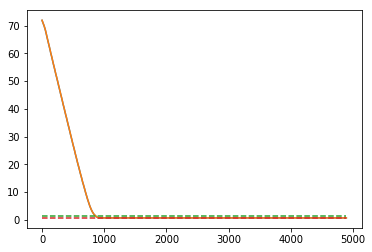

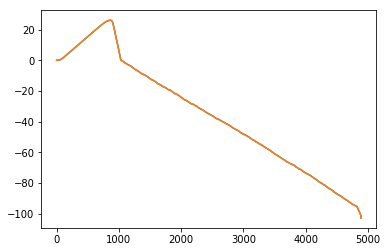

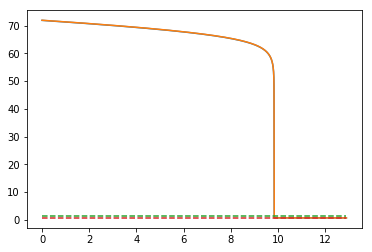

In [9]:
#Nu=i+2
#print(rnpf[1])

print(Nu)
plt.plot(rnpf[0,:])
plt.plot(rnpf[1,:])
plt.plot([0,len(rnpf[0])],[rplus,rplus],'--')
plt.plot([0,len(rnpf[0])],[rminus,rminus],'--')
#plt.ylim(.8,1.5)
plt.show()

plt.plot(signpf[0,:])
plt.plot(signpf[1,:])
#plt.plot([min(urange),max(urange)],[rplus,rplus])
#plt.plot([min(urange),max(urange)],[rminus,rminus])
plt.show()

plt.plot(urange,rnpf[0,:])
plt.plot(urange,rnpf[1,:])
plt.plot([min(urange),max(urange)],[rplus,rplus],'--')
plt.plot([min(urange),max(urange)],[rminus,rminus],'--')
plt.show()
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

#for i in range(0,len(rnpf[0])):
    #print(rnpf[0][i])

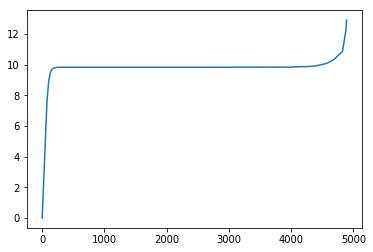

In [10]:
plt.plot(urange)
plt.show()

In [11]:
switch=True
np.save('rnputil',np.array([Nu*Nv,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD,switch]))
np.save('urange',urange0)
np.save('vrange',vrange)

In [12]:
stop = timeit.default_timer()

In [13]:
acttime=stop - start

#numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttimef=(acttime-predtime)/60

exttime=format(abs((acttime-predtime)/60),'.2f')
if exttimef>0.0:
    print("Took "+str(exttime)+" more minutes")
if exttimef<0.0:
    print("Took "+str(exttime)+" less minutes")
if exttimef==0.0:
    print("Took exactly the right time!!!!")

138.53521490800267 seconds
2.3089202484667113 minutes
0.03848200414111185 hours
4047838 points
29218.837987785668 points per second
Took 2.25 more minutes


conv=False
j=0
tempanswer=[]
    while conv==False:
        dv=TempTolv*dv0
        jcount=1
        while j<Nv-1:
            j1=mth.ceil(jcount*TempTolv)
            j2=mth.floor(jcount*TempTolv)
            answer=dnu.x4giveralt(0,j+mth.ceil((jcount-1)*TempTolv),du,dv*TempTolv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
            rnpf[1][j+j1]=answer[0]
            phinpf[1][j+j1]=answer[1]
            signpf[1][j+j1]=answer[2]
            massnpf[1][j+j1]=answer[3]
            #drunptemp[j+1]=answer[4]
            dsigunpv=answer[5]
            jcount=(jcount+1)**(0**j2)
            j=j+j2
        
        if np.abs(tempanswer[0]-answer[0])/answer[0]>0.01 or not tempanswer:
            tempanswer=answer
            TempTol=TempTolv/2
            
        else:
            conv=True
            